## In this notebook, I used my customized facenet model as a tflite version for testing the model performance on the testing sample image.

In [ ]:
!pip install face-detection-tflite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 23.1 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0


In [ ]:
!pip install matplotlib

In [ ]:
import cv2
import numpy as np
import os
from PIL import Image
from fdlite import FaceDetection, FaceDetectionModel
from fdlite.render import Colors, detections_to_render_data
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.cm as cm

In [ ]:
# Initialize the face detection model
detect_faces = FaceDetection(model_type=FaceDetectionModel.BACK_CAMERA)

# Load the TFLite model from the file
tflite_model = open("/content/drive/MyDrive/facenet.tflite", "rb")
interpreter = tf.lite.Interpreter(model_content=tflite_model.read())

# Allocate the tensors
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function to preprocess face images for Facenet model
def extract_embeddings(image_np):
    # Preprocess the image
    image_np = tf.image.resize(image_np, (160, 160))
    image_np = image_np / 255.0
    image_np = np.expand_dims(image_np, axis=0)

    # Set the data for the input tensor.
    interpreter.set_tensor(input_details[0]['index'], image_np)

    # Run the interpreter.
    interpreter.invoke()

    # Get the output
    output = interpreter.get_tensor(output_details[0]['index'])

    return output

In [ ]:
# Load images of known persons and their names
known_faces = {}
for file_name in os.listdir("/content/drive/MyDrive/kids2"):
    img_path = os.path.join("/content/drive/MyDrive/kids2", file_name)
    img = cv2.imread(img_path)
    known_faces[file_name.split('.')[0]] = extract_embeddings(img)

# Read the image file
image_path = "/content/75.jpg"  # Replace with the path to your image file
frame = cv2.imread(image_path)

In [ ]:
print(image_path)

/content/121.jpg


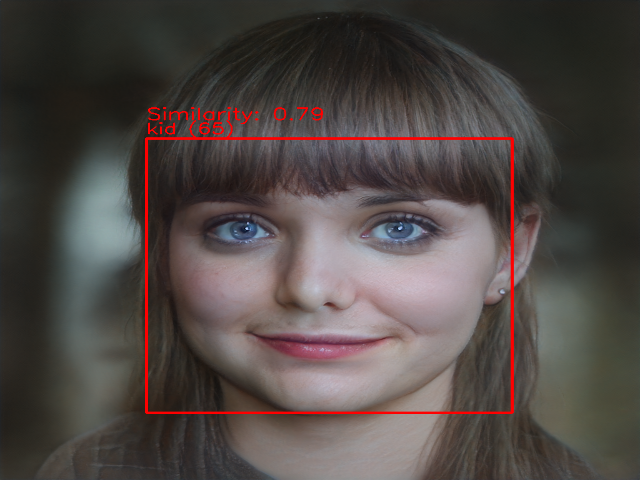

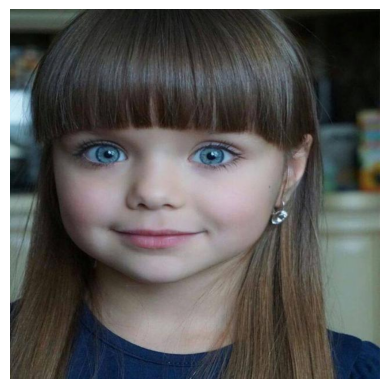

In [ ]:
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# Convert the OpenCV frame to a PIL image
frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Detect faces in the frame
faces = detect_faces(frame_pil)

# Check if any faces are detected
if not len(faces):
    print('No faces detected :(')
else:
    # Convert face detections to render data
    annotations = detections_to_render_data(faces, bounds_color=Colors.GREEN)

    closest_distance = float('inf')
    closest_label = None
    closest_face_path = ""
    closest_bbox = None

    for annotation in annotations:
        for item in annotation.data:
            left, right, top, bottom = (int(item.left * frame.shape[1]), int(item.right * frame.shape[1]),
                                        int(item.top * frame.shape[0]), int(item.bottom * frame.shape[0]))
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2) # 0,0, 255

            face_img = frame[top:bottom, left:right]

            try:
                # Extract embeddings for the detected face
                embeddings = extract_embeddings(face_img)

            except:
                continue

            # Compare embeddings with known faces (the sectret of algorithm sucessetion)setting disntance to infinite distance then override the distance when a smaller one found
            for Id, known_embedding in known_faces.items():
                distance = np.linalg.norm(embeddings - known_embedding) #calculate the embeddings vector between training images and testing image
                if distance < closest_distance:
                    closest_distance = distance #reassign the distance when a smaller one found
                    closest_label = Id
                    closest_face_path = "/content/drive/MyDrive/kids2/" + closest_label + ".jpg"
                    pathh = closest_face_path
                    closest_bbox = (left, top, right, bottom)

    # Draw the bounding box, label, and distance value for the closest match
    if closest_label is not None:
        left, top, right, bottom = closest_bbox
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 4)
        cv2.putText(frame, closest_label, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 0, 255), 2)


        #cv2.putText(frame, f"Distance: {closest_distance[0][0]:.2f}", (left, top - 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)


        cv2.putText(frame, f"Similarity: {1-(closest_distance/100):.2f}", (left, top - 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 2)
        # Display the modified image with the bounding box, label, and distance value
        # Resize the frame to a smaller size
        resized_frame = cv2.resize(frame, (640, 480))  # Adjust the dimensions as needed

        # Display the resized image with the bounding box, label, and distance value
        cv2_imshow(resized_frame)

        #cv2_imshow(frame)

        # Load and display the similar image
        similar_image = cv2.imread(closest_face_path)
        similar_image = cv2.cvtColor(similar_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
        plt.imshow(similar_image)
        plt.axis('off')
        plt.show()